<a href="https://colab.research.google.com/github/saichandrapandraju/TF-Developer/blob/main/3.%20NLP/basic_train_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Apr 13 02:31:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import csv
from tqdm.notebook import tqdm

In [12]:
import tensorflow as tf
tf.random.set_seed(333)
tf.__version__

'2.4.1'

In [21]:
import numpy as np
np.random.seed(333)

In [36]:
import matplotlib.pyplot as plt

**Download and process dataset**

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2021-04-13 02:31:50--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.253.62.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.05s   

2021-04-13 02:31:50 (107 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [3]:
stop_words =  [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [5]:
sentences, labels = [], []

In [6]:
with open('/tmp/bbc-text.csv', 'r') as bbc_file:
  csv_reader = csv.reader(bbc_file, delimiter=',')  ## makes things easier
  next(csv_reader)  ## ignores header
  for row in tqdm(csv_reader):
    labels.append(row[0])
    sentence = row[1]
    for word in stop_words:   ## remove stop words from sentence before appending
      token = ' '+word+' '
      sentence = sentence.replace(token, ' ')    ## replace stop word with space
      sentence = sentence.replace('  ', ' ')     ## remove extra space
    sentences.append(sentence)

In [7]:
assert len(sentences) == len(labels)
print(len(sentences))

2225


**Pre-process the dataset**

In [33]:
## create tunable variables so that it'll be easy to change any of them later

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
lr = 0.01
num_epochs = 30

In [10]:
## split data into train and validation sets

train_size = int(len(sentences) * training_portion)      

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]


print(f"Train samples count : {train_size}\nValidation samples count : {len(sentences)-train_size}")
assert len(train_sentences) == len(train_labels)
assert len(validation_sentences) == len(validation_labels)

Train samples count : 1780
Validation samples count : 445


In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)

In [14]:
tokenizer.fit_on_texts(train_sentences)  ## have to fit on train data only so that it'll learn to deal with unseen words (OOV) in validation datset.

In [15]:
word_index = tokenizer.word_index
len(word_index)   ## it'll have all words present in train data but only use top `vocab_size` words while encoding sentences. So don't think that `num_words` is not working in `Tokenizer` :-).

27285

In [16]:
## as we're giving `max_length` for padding, we have to take care of truncating strategy as well . Default will be `pre`
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_pad_trunc = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
train_pad_trunc.shape

(1780, 120)

In [18]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_pad_trunc = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [19]:
validation_pad_trunc.shape

(445, 120)

In [22]:
label_tokenizer = tf.keras.preprocessing.text.Tokenizer()
label_tokenizer.fit_on_texts(labels)    ## fit on all labels so that no label is missed.
label_word_index = label_tokenizer.word_index

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [25]:
np.unique(np.array(labels))

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype='<U13')

In [26]:
label_word_index

{'business': 2, 'entertainment': 5, 'politics': 3, 'sport': 1, 'tech': 4}

In [27]:
len(label_word_index)

5

In [28]:
training_label_seq.shape, validation_label_seq.shape

((1780, 1), (445, 1))

**Train on basic model**

In [29]:
tf.keras.backend.clear_session()

In [30]:
model1 = tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tf.keras.layers.Dense(24, activation='relu'),
                              tf.keras.layers.Dense(6, activation='softmax')
])

In [31]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model1.fit(train_pad_trunc, training_label_seq, epochs=num_epochs, validation_data=(validation_pad_trunc, validation_label_seq), verbose=2)

Epoch 1/30
56/56 - 3s - loss: 1.7618 - accuracy: 0.2534 - val_loss: 1.7218 - val_accuracy: 0.3034
Epoch 2/30
56/56 - 0s - loss: 1.6856 - accuracy: 0.2680 - val_loss: 1.6296 - val_accuracy: 0.2494
Epoch 3/30
56/56 - 0s - loss: 1.5876 - accuracy: 0.3292 - val_loss: 1.5241 - val_accuracy: 0.4382
Epoch 4/30
56/56 - 0s - loss: 1.4544 - accuracy: 0.5169 - val_loss: 1.3667 - val_accuracy: 0.5708
Epoch 5/30
56/56 - 0s - loss: 1.2578 - accuracy: 0.6854 - val_loss: 1.1629 - val_accuracy: 0.6809
Epoch 6/30
56/56 - 0s - loss: 1.0340 - accuracy: 0.7798 - val_loss: 0.9610 - val_accuracy: 0.8270
Epoch 7/30
56/56 - 0s - loss: 0.8287 - accuracy: 0.8657 - val_loss: 0.7848 - val_accuracy: 0.9146
Epoch 8/30
56/56 - 0s - loss: 0.6463 - accuracy: 0.9393 - val_loss: 0.6299 - val_accuracy: 0.9169
Epoch 9/30
56/56 - 0s - loss: 0.4982 - accuracy: 0.9522 - val_loss: 0.5126 - val_accuracy: 0.9258
Epoch 10/30
56/56 - 0s - loss: 0.3875 - accuracy: 0.9607 - val_loss: 0.4259 - val_accuracy: 0.9371
Epoch 11/30
56/56 -

In [35]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

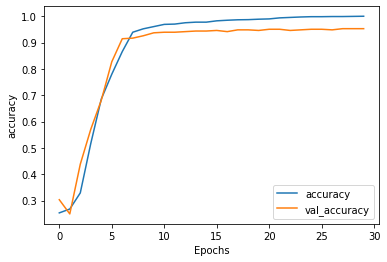

In [37]:
plot_graphs(history, "accuracy")

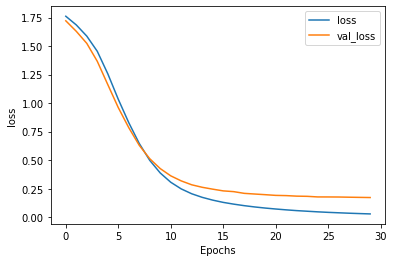

In [38]:
plot_graphs(history, "loss")

**Wrap everything in a function as it'll be easy to experiment with**

In [50]:
def pre_processing(sentences, labels, vocab_size, embed_dim, max_length, oov_tok, train_portion, trunc_type = 'pre', pad_type = 'pre'):
  
  train_size = int(len(sentences) * training_portion) 
  train_sentences = sentences[:train_size]
  train_labels = labels[:train_size]

  validation_sentences = sentences[train_size:]
  validation_labels = labels[train_size:]
  
  assert len(train_sentences) == len(train_labels)
  assert len(validation_sentences) == len(validation_labels)
  print(f"Train samples count : {train_size}\nValidation samples count : {len(sentences)-train_size}")

  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
  tokenizer.fit_on_texts(train_sentences)
  word_index = tokenizer.word_index

  train_sequences = tokenizer.texts_to_sequences(train_sentences)
  train_pad_trunc = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)
  validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
  validation_pad_trunc = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)

  label_tokenizer = tf.keras.preprocessing.text.Tokenizer()
  label_tokenizer.fit_on_texts(labels)    ## fit on all labels so that no label is missed.
  label_word_index = label_tokenizer.word_index

  training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
  validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

  print(f"TRAIN INPUT SHAPE - {train_pad_trunc.shape}, LABELS SHAPE = {training_label_seq.shape}")
  print(f"VALIDATION INPUT SHAPE - {validation_pad_trunc.shape}, LABELS SHAPE = {validation_label_seq.shape}")


  return train_pad_trunc, training_label_seq, validation_pad_trunc, validation_label_seq

**Initial model**

In [53]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
lr = 0.01
num_epochs = 30
loss = 'sparse_categorical_crossentropy'
optimizer='adam'

In [52]:
train_seq, train_labels, val_seq, val_labels = pre_processing(sentences, labels, vocab_size, embedding_dim, max_length, oov_tok, training_portion, trunc_type, padding_type)

Train samples count : 1780
Validation samples count : 445
TRAIN INPUT SHAPE - (1780, 120), LABELS SHAPE = (1780, 1)
VALIDATION INPUT SHAPE - (445, 120), LABELS SHAPE = (445, 1)


In [42]:
del history ## clearing variables
del model
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tf.keras.layers.Dense(24, activation='relu'),
                              tf.keras.layers.Dense(6, activation='softmax')
])

In [54]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [55]:
history = model.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(val_seq, val_labels), verbose=2)

Epoch 1/30
56/56 - 1s - loss: 1.7654 - accuracy: 0.2725 - val_loss: 1.7257 - val_accuracy: 0.3528
Epoch 2/30
56/56 - 0s - loss: 1.6844 - accuracy: 0.3938 - val_loss: 1.6246 - val_accuracy: 0.4292
Epoch 3/30
56/56 - 0s - loss: 1.5731 - accuracy: 0.4730 - val_loss: 1.5036 - val_accuracy: 0.5371
Epoch 4/30
56/56 - 0s - loss: 1.4283 - accuracy: 0.5888 - val_loss: 1.3372 - val_accuracy: 0.6382
Epoch 5/30
56/56 - 0s - loss: 1.2222 - accuracy: 0.7281 - val_loss: 1.1184 - val_accuracy: 0.7618
Epoch 6/30
56/56 - 0s - loss: 0.9737 - accuracy: 0.8556 - val_loss: 0.8856 - val_accuracy: 0.8809
Epoch 7/30
56/56 - 0s - loss: 0.7415 - accuracy: 0.9202 - val_loss: 0.7023 - val_accuracy: 0.8899
Epoch 8/30
56/56 - 0s - loss: 0.5648 - accuracy: 0.9348 - val_loss: 0.5630 - val_accuracy: 0.9034
Epoch 9/30
56/56 - 0s - loss: 0.4379 - accuracy: 0.9466 - val_loss: 0.4673 - val_accuracy: 0.9101
Epoch 10/30
56/56 - 0s - loss: 0.3495 - accuracy: 0.9522 - val_loss: 0.4069 - val_accuracy: 0.9124
Epoch 11/30
56/56 -

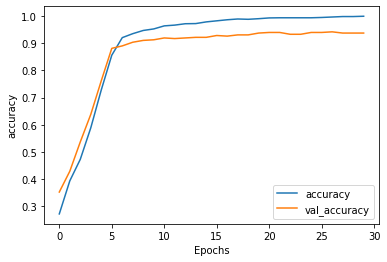

In [56]:
plot_graphs(history, "accuracy")

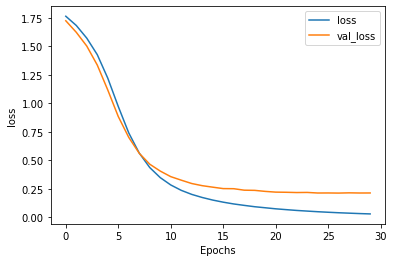

In [57]:
plot_graphs(history, "loss")

**increase vocab size**

In [58]:
vocab_size = 20000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
lr = 0.01
num_epochs = 30
loss = 'sparse_categorical_crossentropy'
optimizer='adam'

In [59]:
train_seq, train_labels, val_seq, val_labels = pre_processing(sentences, labels, vocab_size, embedding_dim, max_length, oov_tok, training_portion, trunc_type, padding_type)

Train samples count : 1780
Validation samples count : 445
TRAIN INPUT SHAPE - (1780, 120), LABELS SHAPE = (1780, 1)
VALIDATION INPUT SHAPE - (445, 120), LABELS SHAPE = (445, 1)


In [60]:
del history ## clearing variables
del model
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tf.keras.layers.Dense(24, activation='relu'),
                              tf.keras.layers.Dense(6, activation='softmax')
])

In [61]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [62]:
history = model.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(val_seq, val_labels), verbose=2)

Epoch 1/30
56/56 - 1s - loss: 1.7582 - accuracy: 0.2483 - val_loss: 1.7088 - val_accuracy: 0.2449
Epoch 2/30
56/56 - 0s - loss: 1.6290 - accuracy: 0.3966 - val_loss: 1.5310 - val_accuracy: 0.5551
Epoch 3/30
56/56 - 0s - loss: 1.3719 - accuracy: 0.8146 - val_loss: 1.2374 - val_accuracy: 0.8382
Epoch 4/30
56/56 - 0s - loss: 1.0031 - accuracy: 0.9410 - val_loss: 0.8891 - val_accuracy: 0.9169
Epoch 5/30
56/56 - 0s - loss: 0.6451 - accuracy: 0.9781 - val_loss: 0.6194 - val_accuracy: 0.9438
Epoch 6/30
56/56 - 0s - loss: 0.4000 - accuracy: 0.9888 - val_loss: 0.4498 - val_accuracy: 0.9483
Epoch 7/30
56/56 - 0s - loss: 0.2523 - accuracy: 0.9938 - val_loss: 0.3469 - val_accuracy: 0.9461
Epoch 8/30
56/56 - 0s - loss: 0.1650 - accuracy: 0.9949 - val_loss: 0.2841 - val_accuracy: 0.9551
Epoch 9/30
56/56 - 0s - loss: 0.1125 - accuracy: 0.9966 - val_loss: 0.2445 - val_accuracy: 0.9483
Epoch 10/30
56/56 - 0s - loss: 0.0800 - accuracy: 0.9983 - val_loss: 0.2202 - val_accuracy: 0.9551
Epoch 11/30
56/56 -

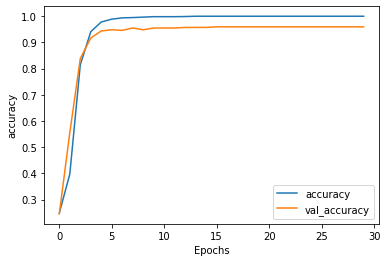

In [63]:
plot_graphs(history, "accuracy")

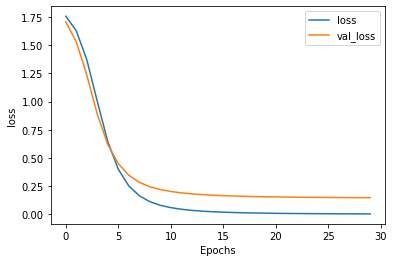

In [64]:
plot_graphs(history, "loss")

RESULT - VALIDATION ACCURACY improved from 94.16 to 95.96

**increase dimensions**

In [79]:
vocab_size = 20000
embedding_dim = 160
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
lr = 0.01
num_epochs = 30
loss = 'sparse_categorical_crossentropy'
optimizer='adam'

In [80]:
train_seq, train_labels, val_seq, val_labels = pre_processing(sentences, labels, vocab_size, embedding_dim, max_length, oov_tok, training_portion, trunc_type, padding_type)

Train samples count : 1780
Validation samples count : 445
TRAIN INPUT SHAPE - (1780, 120), LABELS SHAPE = (1780, 1)
VALIDATION INPUT SHAPE - (445, 120), LABELS SHAPE = (445, 1)


In [81]:
del history ## clearing variables
del model
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tf.keras.layers.Dense(24, activation='relu'),
                              tf.keras.layers.Dense(6, activation='softmax')
])

In [82]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [83]:
history = model.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(val_seq, val_labels), verbose=2)

Epoch 1/30
56/56 - 2s - loss: 1.7006 - accuracy: 0.7230 - val_loss: 1.5258 - val_accuracy: 0.9101
Epoch 2/30
56/56 - 2s - loss: 1.1389 - accuracy: 0.9629 - val_loss: 0.7780 - val_accuracy: 0.9416
Epoch 3/30
56/56 - 2s - loss: 0.4089 - accuracy: 0.9843 - val_loss: 0.3343 - val_accuracy: 0.9528
Epoch 4/30
56/56 - 2s - loss: 0.1368 - accuracy: 0.9933 - val_loss: 0.2184 - val_accuracy: 0.9640
Epoch 5/30
56/56 - 2s - loss: 0.0616 - accuracy: 0.9978 - val_loss: 0.1743 - val_accuracy: 0.9663
Epoch 6/30
56/56 - 2s - loss: 0.0336 - accuracy: 1.0000 - val_loss: 0.1546 - val_accuracy: 0.9685
Epoch 7/30
56/56 - 2s - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.1427 - val_accuracy: 0.9685
Epoch 8/30
56/56 - 2s - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.1346 - val_accuracy: 0.9685
Epoch 9/30
56/56 - 2s - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.1294 - val_accuracy: 0.9708
Epoch 10/30
56/56 - 2s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.1256 - val_accuracy: 0.9708
Epoch 11/30
56/56 -

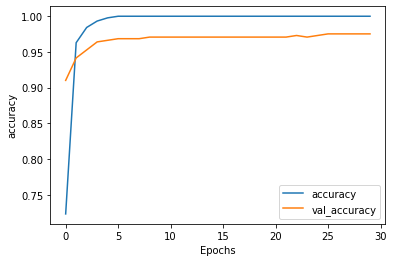

In [84]:
plot_graphs(history, "accuracy")

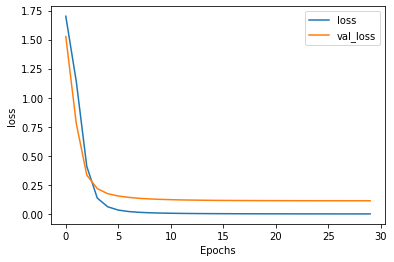

In [85]:
plot_graphs(history, "loss")

RESULT - VALIDATION ACCURACY started with 91.01 and reached 95.28 in 3 epochs itself AND improved from 95.96 to 97.53. TRAINING TIME increased

**increase max length**

In [86]:
vocab_size = 20000
embedding_dim = 160
max_length = 512
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
lr = 0.01
num_epochs = 30
loss = 'sparse_categorical_crossentropy'
optimizer='adam'

In [87]:
train_seq, train_labels, val_seq, val_labels = pre_processing(sentences, labels, vocab_size, embedding_dim, max_length, oov_tok, training_portion, trunc_type, padding_type)

Train samples count : 1780
Validation samples count : 445
TRAIN INPUT SHAPE - (1780, 512), LABELS SHAPE = (1780, 1)
VALIDATION INPUT SHAPE - (445, 512), LABELS SHAPE = (445, 1)


In [101]:
del history ## clearing variables
del model
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tf.keras.layers.Dense(24, activation='relu'),
                              tf.keras.layers.Dense(6, activation='softmax')
])

In [102]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [103]:
history = model.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(val_seq, val_labels), verbose=2)

Epoch 1/30
56/56 - 2s - loss: 1.7204 - accuracy: 0.2629 - val_loss: 1.6181 - val_accuracy: 0.2562
Epoch 2/30
56/56 - 2s - loss: 1.5104 - accuracy: 0.3702 - val_loss: 1.4004 - val_accuracy: 0.4292
Epoch 3/30
56/56 - 2s - loss: 1.2165 - accuracy: 0.6657 - val_loss: 1.0519 - val_accuracy: 0.8067
Epoch 4/30
56/56 - 2s - loss: 0.8191 - accuracy: 0.9135 - val_loss: 0.6978 - val_accuracy: 0.9191
Epoch 5/30
56/56 - 2s - loss: 0.4910 - accuracy: 0.9674 - val_loss: 0.4724 - val_accuracy: 0.9303
Epoch 6/30
56/56 - 2s - loss: 0.2997 - accuracy: 0.9809 - val_loss: 0.3486 - val_accuracy: 0.9348
Epoch 7/30
56/56 - 2s - loss: 0.1932 - accuracy: 0.9904 - val_loss: 0.2696 - val_accuracy: 0.9596
Epoch 8/30
56/56 - 2s - loss: 0.1323 - accuracy: 0.9944 - val_loss: 0.2184 - val_accuracy: 0.9640
Epoch 9/30
56/56 - 2s - loss: 0.0948 - accuracy: 0.9949 - val_loss: 0.1877 - val_accuracy: 0.9685
Epoch 10/30
56/56 - 2s - loss: 0.0692 - accuracy: 0.9972 - val_loss: 0.1666 - val_accuracy: 0.9685
Epoch 11/30
56/56 -

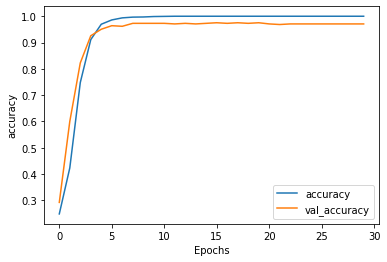

In [99]:
plot_graphs(history, "accuracy")

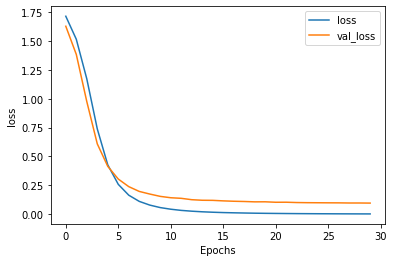

In [100]:
plot_graphs(history, "loss")

RESULT - nothing much improved

**try `rmsprop` optimizer**

In [104]:
vocab_size = 20000
embedding_dim = 160
max_length = 512
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
lr = 0.01
num_epochs = 30
loss = 'sparse_categorical_crossentropy'
optimizer='rmsprop'

In [105]:
train_seq, train_labels, val_seq, val_labels = pre_processing(sentences, labels, vocab_size, embedding_dim, max_length, oov_tok, training_portion, trunc_type, padding_type)

Train samples count : 1780
Validation samples count : 445
TRAIN INPUT SHAPE - (1780, 512), LABELS SHAPE = (1780, 1)
VALIDATION INPUT SHAPE - (445, 512), LABELS SHAPE = (445, 1)


In [106]:
del history ## clearing variables
del model
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tf.keras.layers.Dense(24, activation='relu'),
                              tf.keras.layers.Dense(6, activation='softmax')
])

In [107]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [108]:
history = model.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(val_seq, val_labels), verbose=2)

Epoch 1/30
56/56 - 1s - loss: 1.7340 - accuracy: 0.3910 - val_loss: 1.6585 - val_accuracy: 0.4944
Epoch 2/30
56/56 - 1s - loss: 1.5463 - accuracy: 0.5573 - val_loss: 1.4329 - val_accuracy: 0.6607
Epoch 3/30
56/56 - 1s - loss: 1.2699 - accuracy: 0.7382 - val_loss: 1.1321 - val_accuracy: 0.8562
Epoch 4/30
56/56 - 1s - loss: 0.9550 - accuracy: 0.8747 - val_loss: 0.8459 - val_accuracy: 0.9303
Epoch 5/30
56/56 - 1s - loss: 0.6815 - accuracy: 0.9449 - val_loss: 0.6310 - val_accuracy: 0.9236
Epoch 6/30
56/56 - 1s - loss: 0.4640 - accuracy: 0.9556 - val_loss: 0.4611 - val_accuracy: 0.9326
Epoch 7/30
56/56 - 1s - loss: 0.3070 - accuracy: 0.9680 - val_loss: 0.3280 - val_accuracy: 0.9596
Epoch 8/30
56/56 - 1s - loss: 0.2013 - accuracy: 0.9770 - val_loss: 0.2411 - val_accuracy: 0.9640
Epoch 9/30
56/56 - 1s - loss: 0.1323 - accuracy: 0.9882 - val_loss: 0.1920 - val_accuracy: 0.9730
Epoch 10/30
56/56 - 1s - loss: 0.0901 - accuracy: 0.9899 - val_loss: 0.1538 - val_accuracy: 0.9730
Epoch 11/30
56/56 -

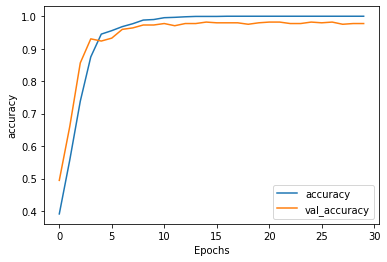

In [109]:
plot_graphs(history, "accuracy")

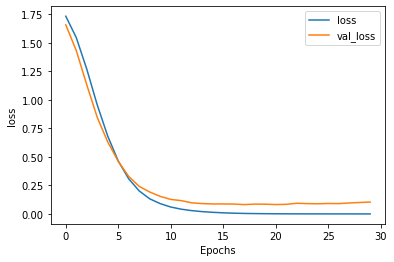

In [110]:
plot_graphs(history, "loss")

RESULT - VALIDATION ACCURACY improved from 97.53 to 98.2 and a bit shaky AND TRAINING TIME decreased

**increase neurons**

In [111]:
vocab_size = 20000
embedding_dim = 160
max_length = 512
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
lr = 0.01
num_epochs = 30
loss = 'sparse_categorical_crossentropy'
optimizer='adam'

In [112]:
train_seq, train_labels, val_seq, val_labels = pre_processing(sentences, labels, vocab_size, embedding_dim, max_length, oov_tok, training_portion, trunc_type, padding_type)

Train samples count : 1780
Validation samples count : 445
TRAIN INPUT SHAPE - (1780, 512), LABELS SHAPE = (1780, 1)
VALIDATION INPUT SHAPE - (445, 512), LABELS SHAPE = (445, 1)


In [116]:
del history ## clearing variables
del model
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tf.keras.layers.Dense(64, activation='relu'),
                              tf.keras.layers.Dense(6, activation='softmax')
])

In [117]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [118]:
history = model.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(val_seq, val_labels), verbose=2)

Epoch 1/30
56/56 - 2s - loss: 1.7021 - accuracy: 0.2910 - val_loss: 1.5787 - val_accuracy: 0.4562
Epoch 2/30
56/56 - 2s - loss: 1.4171 - accuracy: 0.5685 - val_loss: 1.2394 - val_accuracy: 0.6584
Epoch 3/30
56/56 - 2s - loss: 0.9744 - accuracy: 0.8725 - val_loss: 0.7691 - val_accuracy: 0.9326
Epoch 4/30
56/56 - 2s - loss: 0.5167 - accuracy: 0.9601 - val_loss: 0.4323 - val_accuracy: 0.9640
Epoch 5/30
56/56 - 2s - loss: 0.2580 - accuracy: 0.9798 - val_loss: 0.2823 - val_accuracy: 0.9708
Epoch 6/30
56/56 - 2s - loss: 0.1426 - accuracy: 0.9927 - val_loss: 0.2108 - val_accuracy: 0.9753
Epoch 7/30
56/56 - 2s - loss: 0.0869 - accuracy: 0.9961 - val_loss: 0.1673 - val_accuracy: 0.9730
Epoch 8/30
56/56 - 2s - loss: 0.0568 - accuracy: 0.9978 - val_loss: 0.1414 - val_accuracy: 0.9775
Epoch 9/30
56/56 - 2s - loss: 0.0399 - accuracy: 0.9994 - val_loss: 0.1258 - val_accuracy: 0.9798
Epoch 10/30
56/56 - 2s - loss: 0.0286 - accuracy: 0.9994 - val_loss: 0.1146 - val_accuracy: 0.9775
Epoch 11/30
56/56 -

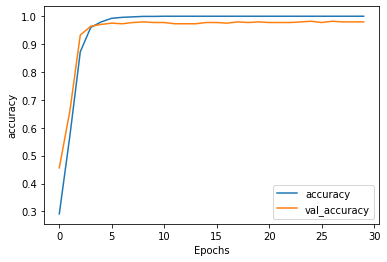

In [119]:
plot_graphs(history, "accuracy")

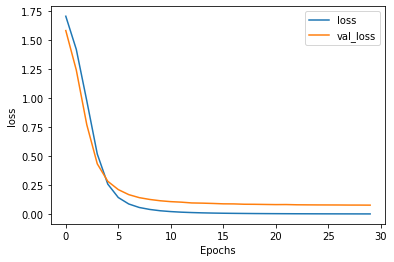

In [120]:
plot_graphs(history, "loss")

RESULT - nothing improved but VALIDATION ACCURACY graph is a bit smoother

**add layers**

In [135]:
vocab_size = 20000
embedding_dim = 160
max_length = 512
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
lr = 0.01
num_epochs = 30
loss = 'sparse_categorical_crossentropy'
optimizer='rmsprop'

In [136]:
train_seq, train_labels, val_seq, val_labels = pre_processing(sentences, labels, vocab_size, embedding_dim, max_length, oov_tok, training_portion, trunc_type, padding_type)

Train samples count : 1780
Validation samples count : 445
TRAIN INPUT SHAPE - (1780, 512), LABELS SHAPE = (1780, 1)
VALIDATION INPUT SHAPE - (445, 512), LABELS SHAPE = (445, 1)


In [137]:
del history ## clearing variables
del model
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
                              tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                              tf.keras.layers.GlobalAveragePooling1D(),
                              tf.keras.layers.Dense(64, activation='relu'),
                              tf.keras.layers.Dense(32, activation='relu'),
                              tf.keras.layers.Dense(6, activation='softmax')
])

In [138]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [139]:
history = model.fit(train_seq, train_labels, epochs=num_epochs, validation_data=(val_seq, val_labels), verbose=2)

Epoch 1/30
56/56 - 2s - loss: 1.6876 - accuracy: 0.3640 - val_loss: 1.5449 - val_accuracy: 0.3910
Epoch 2/30
56/56 - 1s - loss: 1.3930 - accuracy: 0.5140 - val_loss: 1.2429 - val_accuracy: 0.6315
Epoch 3/30
56/56 - 1s - loss: 1.0339 - accuracy: 0.6787 - val_loss: 0.8795 - val_accuracy: 0.8494
Epoch 4/30
56/56 - 1s - loss: 0.6735 - accuracy: 0.8770 - val_loss: 0.5777 - val_accuracy: 0.9079
Epoch 5/30
56/56 - 1s - loss: 0.3846 - accuracy: 0.9663 - val_loss: 0.4055 - val_accuracy: 0.8899
Epoch 6/30
56/56 - 1s - loss: 0.1957 - accuracy: 0.9809 - val_loss: 0.2581 - val_accuracy: 0.9258
Epoch 7/30
56/56 - 1s - loss: 0.1013 - accuracy: 0.9876 - val_loss: 0.1821 - val_accuracy: 0.9506
Epoch 8/30
56/56 - 1s - loss: 0.0558 - accuracy: 0.9910 - val_loss: 0.1436 - val_accuracy: 0.9596
Epoch 9/30
56/56 - 1s - loss: 0.0315 - accuracy: 0.9961 - val_loss: 0.1433 - val_accuracy: 0.9461
Epoch 10/30
56/56 - 1s - loss: 0.0200 - accuracy: 0.9966 - val_loss: 0.1098 - val_accuracy: 0.9640
Epoch 11/30
56/56 -

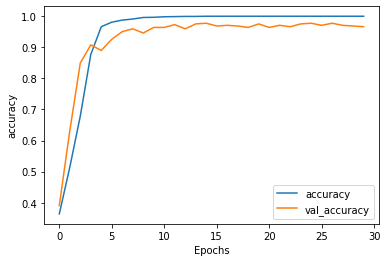

In [140]:
plot_graphs(history, "accuracy")

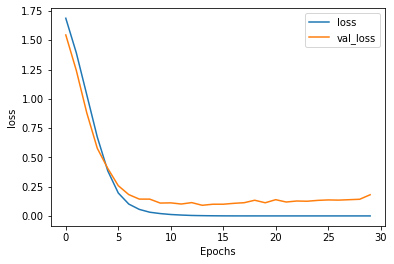

In [141]:
plot_graphs(history, "loss")